In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import os
os.makedirs('models', exist_ok=True)

In [2]:
from sklearn.metrics import root_mean_squared_error

In [3]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-experiment")

2025/07/16 03:36:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/16 03:36:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025/07/16 03:36:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-Experiment Tracking/mlruns/1', creation_time=1752018549946, experiment_id='1', last_update_time=1752018549946, lifecycle_stage='active', name='my-experiment', tags={}>

In [4]:
path1 = './yellow_tripdata_2024-01.parquet'
path2 = './yellow_tripdata_2024-02.parquet'

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    #df.head()
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # filter
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str) #int -> str
    
    return df


In [6]:
df_train = read_dataframe(path1).sample(10000, random_state=1)
df_val = read_dataframe(path2).sample(10000, random_state=1)

In [7]:
#td = df.duration.iloc[0]
#td.total_seconds()
#df.duration.describe(percentiles=[0.95, 0.98, 0.99])
#numerical = ['trip_distance']
#df[categorical].dtypes
#len(df_train) == len(df_val)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
#categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer() #DictVectorizer는 딕셔너리 형태의 데이터를 머신러닝 모델이 사용할 수 있는 행렬(벡터)로 변환합니다.

#DataFrame에서 범주형(categorical)과 수치형(numerical) 컬럼만 선택해, 각 행을 딕셔너리로 변환합니다.
#결과는 딕셔너리의 리스트가 됩니다. (예: [{'col1': val1, 'col2': val2, ...}, ...])
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

#fit_transform은 학습과 변환을 동시에 수행합니다.
#X_train은 변환된 특성 행렬(2차원 배열, sparse matrix)입니다.
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

#예측하고자 하는 목표값(여기서는 'duration' 컬럼)을 y_train에 저장합니다.
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values



In [10]:
#선형회귀 모델을 생성하고, X_train(특성)과 y_train(목표값)으로 학습시킵니다.
lr = LinearRegression()
lr.fit(X_train, y_train)

#학습된 모델로 X_train에 대한 예측값을 구합니다.
y_pred = lr.predict(X_train)

#회귀 문제에서 예측값과 실제값의 차이를 제곱해 평균을 낸 값(MSE, 평균제곱오차)을 계산
mean_squared_error(y_train, y_pred)

14.595657517143144

/tmp/ipykernel_16043/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_16043/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')
/tmp/ipykernel_16043/1672306066.py:2: UserWarning: 

`distplot` is a deprec

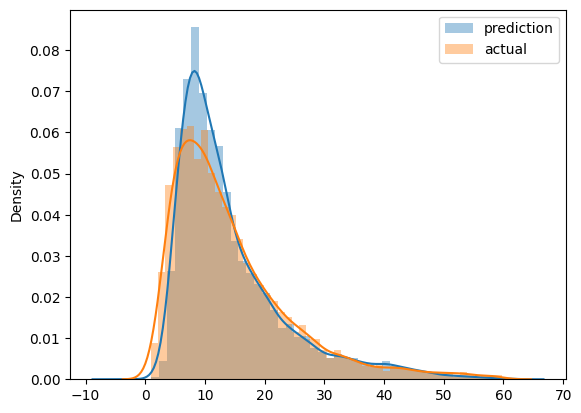

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:


with mlflow.start_run():
    mlflow.set_tag("dev", "josh")
    mlflow.log_param("train-data-path", path1)
    mlflow.log_param("val-data-path", path2)
    
    alpha = 0.001
    mlflow.log_param("alpha", alpha)
    lr = Ridge(alpha) 
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    rmse = root_mean_squared_error(y_train, y_pred)
    mlflow.log_metric("rmse", rmse)

In [13]:
#'models/lin_reg.bin' 파일을 바이너리 쓰기 모드('wb')로 엽니다.
# pickle.dump((dv, lr), f_out)는 dv와 lr 객체를 튜플로 묶어 파일에 저장합니다.
#with open('models/lin_reg.bin', 'wb') as f_out:
#    pickle.dump((dv, lr), f_out)    

In [14]:
import xgboost as xgb
# 최적의 hyper parameter set을 찾기 위해 Bayesian Optimization을 사용하는 라이브러리
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

In [15]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [16]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("models", "xgboost")
        if isinstance(params, dict):
            for k, v in params.items():
                mlflow.log_param(k, v)
        else:
            mlflow.log_param("params", params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )

        # 예측 및 RMSE 계산
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        
        # 메트릭 기록
        mlflow.log_metric("rmse", rmse)
        return {'loss': rmse, 'status': STATUS_OK}

In [17]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:36:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.38210                           
[0]	validation-rmse:9.382100<?, ?trial/s, best loss=?]
[1]	validation-rmse:8.70063                           
[1]	validation-rmse:8.70063                           
[2]	validation-rmse:8.13974                           
[2]	validation-rmse:8.13974                           
[3]	validation-rmse:7.67971                           
[3]	validation-rmse:7.67971                           
[4]	validation-rmse:7.28991                           
[4]	validation-rmse:7.28991                           
[5]	validation-rmse:6.97256                           
[5]	validation-rmse:6.97256                           
[6]	validation-rmse:6.73126                           
[6]	validation-rmse:6.73126                           
[7]	validation-rmse:6.53476                           
[7]	validation-rmse:6.53476                           
[8]	validation-rmse:6.36493                           
[8]	validation-rmse:6.36493                           
[9]	valida

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:36:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:5.65915                                                   
[7]	validation-rmse:5.659157<06:11,  7.59s/trial, best loss: 5.74913051946994]
[8]	validation-rmse:5.65355                                                   
[8]	validation-rmse:5.65355                                                   
[9]	validation-rmse:5.65426                                                   
[9]	validation-rmse:5.65426                                                   
[10]	validation-rmse:5.64987                                                  
[10]	validation-rmse:5.64987                                                  
[11]	validation-rmse:5.64847                                                  
[11]	validation-rmse:5.64847                                                  
[12]	validation-rmse:5.64887                                                  
[12]	validation-rmse:5.64887                                                  
[13]	validation-rmse:5.64658                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:36:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36757                                                    
[0]	validation-rmse:8.367579<03:05,  3.87s/trial, best loss: 5.629507947459021]
[1]	validation-rmse:7.22595                                                    
[1]	validation-rmse:7.22595                                                    
[2]	validation-rmse:6.54833                                                    
[2]	validation-rmse:6.54833                                                    
[3]	validation-rmse:6.16905                                                    
[3]	validation-rmse:6.16905                                                    
[4]	validation-rmse:5.95321                                                    
[4]	validation-rmse:5.95321                                                    
[5]	validation-rmse:5.84327                                                    
[5]	validation-rmse:5.84327                                                    
[6]	validation-rmse:5.78315             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:36:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:8.68358                                                    
[4]	validation-rmse:8.683583<03:03,  3.91s/trial, best loss: 5.629507947459021]
[5]	validation-rmse:8.44242                                                    
[5]	validation-rmse:8.44242                                                    
[6]	validation-rmse:8.21872                                                    
[6]	validation-rmse:8.21872                                                    
[7]	validation-rmse:8.01152                                                    
[7]	validation-rmse:8.01152                                                    
[8]	validation-rmse:7.81982                                                    
[8]	validation-rmse:7.81982                                                    
[9]	validation-rmse:7.64269                                                    
[9]	validation-rmse:7.64269                                                    
[10]	validation-rmse:7.47920            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:36:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.72672                                                    
[0]	validation-rmse:9.726729<03:44,  4.87s/trial, best loss: 5.629507947459021]
[1]	validation-rmse:9.30402                                                    
[1]	validation-rmse:9.30402                                                    
[2]	validation-rmse:8.91945                                                    
[2]	validation-rmse:8.91945                                                    
[3]	validation-rmse:8.57589                                                    
[3]	validation-rmse:8.57589                                                    
[4]	validation-rmse:8.26120                                                    
[4]	validation-rmse:8.26120                                                    
[5]	validation-rmse:7.98373                                                    
[5]	validation-rmse:7.98373                                                    
[6]	validation-rmse:7.72476             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.43292
 10%|█         | 5/50 [00:28<04:46,  6.37s/trial, best loss: 5.629507947459021][2]	validation-rmse:7.43292
[3]	validation-rmse:6.93188                                                    
[3]	validation-rmse:6.93188                                                    
[4]	validation-rmse:6.56646                                                    
[4]	validation-rmse:6.56646                                                    
[5]	validation-rmse:6.30294                                                    
[5]	validation-rmse:6.30294                                                    
[6]	validation-rmse:6.11734                                                    
[6]	validation-rmse:6.11734                                                    
[7]	validation-rmse:5.98407                                                    
[7]	validation-rmse:5.98407                                                    
[8]	validation-rmse:5.89342                                      

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.29165                                                    
[3]	validation-rmse:6.291653<04:24,  6.02s/trial, best loss: 5.629507947459021]
[4]	validation-rmse:6.05228                                                    
[4]	validation-rmse:6.05228                                                    
[5]	validation-rmse:5.91579                                                    
[5]	validation-rmse:5.91579                                                    
[6]	validation-rmse:5.83734                                                    
[6]	validation-rmse:5.83734                                                    
[7]	validation-rmse:5.79338                                                    
[7]	validation-rmse:5.79338                                                    
[8]	validation-rmse:5.76662                                                    
[8]	validation-rmse:5.76662                                                    
[9]	validation-rmse:5.74956             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.14164                                                    
[2]	validation-rmse:9.141645<03:23,  4.73s/trial, best loss: 5.629507947459021]
[3]	validation-rmse:8.84267                                                    
[3]	validation-rmse:8.84267                                                    
[4]	validation-rmse:8.56613                                                    
[4]	validation-rmse:8.56613                                                    
[5]	validation-rmse:8.31158                                                    
[5]	validation-rmse:8.31158                                                    
[6]	validation-rmse:8.07675                                                    
[6]	validation-rmse:8.07675                                                    
[7]	validation-rmse:7.86087                                                    
[7]	validation-rmse:7.86087                                                    
[8]	validation-rmse:7.66275             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.72938                                                    
[3]	validation-rmse:5.729387<04:55,  7.03s/trial, best loss: 5.629507947459021]
[4]	validation-rmse:5.72673                                                    
[4]	validation-rmse:5.72673                                                    
[5]	validation-rmse:5.73037                                                    
[5]	validation-rmse:5.73037                                                    
[6]	validation-rmse:5.72617                                                    
[6]	validation-rmse:5.72617                                                    
[7]	validation-rmse:5.72970                                                    
[7]	validation-rmse:5.72970                                                    
[8]	validation-rmse:5.72767                                                    
[8]	validation-rmse:5.72767                                                    
[9]	validation-rmse:5.73119             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49138                                                    
[0]	validation-rmse:8.491389<03:33,  5.20s/trial, best loss: 5.629507947459021]
[1]	validation-rmse:7.40349                                                    
[1]	validation-rmse:7.40349                                                    
[2]	validation-rmse:6.73091                                                    
[2]	validation-rmse:6.73091                                                    
[3]	validation-rmse:6.34121                                                    
[3]	validation-rmse:6.34121                                                    
[4]	validation-rmse:6.11554                                                    
[4]	validation-rmse:6.11554                                                    
[5]	validation-rmse:5.95838                                                    
[5]	validation-rmse:5.95838                                                    
[6]	validation-rmse:5.89058             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.67355                                                     
[0]	validation-rmse:6.6735553<03:17,  4.95s/trial, best loss: 5.629507947459021]
[1]	validation-rmse:5.91166                                                     
[1]	validation-rmse:5.91166                                                     
[2]	validation-rmse:5.77599                                                     
[2]	validation-rmse:5.77599                                                     
[3]	validation-rmse:5.77939                                                     
[3]	validation-rmse:5.77939                                                     
[4]	validation-rmse:5.77713                                                     
[4]	validation-rmse:5.77713                                                     
[5]	validation-rmse:5.78271                                                     
[5]	validation-rmse:5.78271                                                     
[6]	validation-rmse:5.78806 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.66814                                                     
[3]	validation-rmse:5.6681455<02:38,  4.06s/trial, best loss: 5.629507947459021]
[4]	validation-rmse:5.66007                                                     
[4]	validation-rmse:5.66007                                                     
[5]	validation-rmse:5.65707                                                     
[5]	validation-rmse:5.65707                                                     
[6]	validation-rmse:5.65626                                                     
[6]	validation-rmse:5.65626                                                     
[7]	validation-rmse:5.65852                                                     
[7]	validation-rmse:5.65852                                                     
[8]	validation-rmse:5.66394                                                     
[8]	validation-rmse:5.66394                                                     
[9]	validation-rmse:5.66441 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.74998                                                     
[4]	validation-rmse:5.7499856<01:59,  3.14s/trial, best loss: 5.629507947459021]
[5]	validation-rmse:5.72347                                                     
[5]	validation-rmse:5.72347                                                     
[6]	validation-rmse:5.70993                                                     
[6]	validation-rmse:5.70993                                                     
[7]	validation-rmse:5.70060                                                     
[7]	validation-rmse:5.70060                                                     
[8]	validation-rmse:5.69689                                                     
[8]	validation-rmse:5.69689                                                     
[9]	validation-rmse:5.69357                                                     
[9]	validation-rmse:5.69357                                                     
[10]	validation-rmse:5.69083

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.40095                                                     
[0]	validation-rmse:9.4009558<01:38,  2.65s/trial, best loss: 5.629507947459021]
[1]	validation-rmse:8.73380                                                     
[1]	validation-rmse:8.73380                                                     
[2]	validation-rmse:8.17445                                                     
[2]	validation-rmse:8.17445                                                     
[3]	validation-rmse:7.70749                                                     
[3]	validation-rmse:7.70749                                                     
[4]	validation-rmse:7.32316                                                     
[4]	validation-rmse:7.32316                                                     
[5]	validation-rmse:7.00741                                                     
[5]	validation-rmse:7.00741                                                     
[6]	validation-rmse:6.74401 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.81915                                                     
[1]	validation-rmse:5.8191507<02:48,  4.69s/trial, best loss: 5.629507947459021]
[2]	validation-rmse:5.72677                                                     
[2]	validation-rmse:5.72677                                                     
[3]	validation-rmse:5.71598                                                     
[3]	validation-rmse:5.71598                                                     
[4]	validation-rmse:5.70747                                                     
[4]	validation-rmse:5.70747                                                     
[5]	validation-rmse:5.70322                                                     
[5]	validation-rmse:5.70322                                                     
[6]	validation-rmse:5.70158                                                     
[6]	validation-rmse:5.70158                                                     
[7]	validation-rmse:5.70101 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.71205                                                     
[3]	validation-rmse:5.7120508<02:10,  3.72s/trial, best loss: 5.629507947459021]
[4]	validation-rmse:5.67589                                                     
[4]	validation-rmse:5.67589                                                     
[5]	validation-rmse:5.65792                                                     
[5]	validation-rmse:5.65792                                                     
[6]	validation-rmse:5.64968                                                     
[6]	validation-rmse:5.64968                                                     
[7]	validation-rmse:5.65315                                                     
[7]	validation-rmse:5.65315                                                     
[8]	validation-rmse:5.65040                                                     
[8]	validation-rmse:5.65040                                                     
[9]	validation-rmse:5.64807 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.21159                                                     
[3]	validation-rmse:7.2115910<01:48,  3.20s/trial, best loss: 5.629507947459021]
[4]	validation-rmse:6.83285                                                     
[4]	validation-rmse:6.83285                                                     
[5]	validation-rmse:6.54654                                                     
[5]	validation-rmse:6.54654                                                     
[6]	validation-rmse:6.33218                                                     
[6]	validation-rmse:6.33218                                                     
[7]	validation-rmse:6.17310                                                     
[7]	validation-rmse:6.17310                                                     
[8]	validation-rmse:6.05588                                                     
[8]	validation-rmse:6.05588                                                     
[9]	validation-rmse:5.96995 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.89527                                                     
[4]	validation-rmse:6.8952713<01:37,  2.95s/trial, best loss: 5.629507947459021]
[5]	validation-rmse:6.60322                                                     
[5]	validation-rmse:6.60322                                                     
[6]	validation-rmse:6.38200                                                     
[6]	validation-rmse:6.38200                                                     
[7]	validation-rmse:6.21552                                                     
[7]	validation-rmse:6.21552                                                     
[8]	validation-rmse:6.09124                                                     
[8]	validation-rmse:6.09124                                                     
[9]	validation-rmse:5.99860                                                     
[9]	validation-rmse:5.99860                                                     
[10]	validation-rmse:5.92996

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.74180                                                     
[1]	validation-rmse:5.7418015<01:32,  2.90s/trial, best loss: 5.629507947459021]
[2]	validation-rmse:5.74834                                                     
[2]	validation-rmse:5.74834                                                     
[3]	validation-rmse:5.75047                                                     
[3]	validation-rmse:5.75047                                                     
[4]	validation-rmse:5.74376                                                     
[4]	validation-rmse:5.74376                                                     
[5]	validation-rmse:5.75332                                                     
[5]	validation-rmse:5.75332                                                     
[6]	validation-rmse:5.75042                                                     
[6]	validation-rmse:5.75042                                                     
[7]	validation-rmse:5.75559 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:7.27554
[11]	validation-rmse:7.12430                                                    
[11]	validation-rmse:7.12430                                                    
[12]	validation-rmse:6.98639                                                    
[12]	validation-rmse:6.98639                                                    
[13]	validation-rmse:6.86121                                                    
[13]	validation-rmse:6.86121                                                    
[14]	validation-rmse:6.74796                                                    
[14]	validation-rmse:6.74796                                                    
[15]	validation-rmse:6.64320                                                    
[15]	validation-rmse:6.64320                                                    
[16]	validation-rmse:6.55017                                                    
[16]	validation-rmse:6.550177<01:14,  2.42s/trial, best loss: 5.629507947459021]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:5.66304                                                     
[7]	validation-rmse:5.6630419<01:10,  2.36s/trial, best loss: 5.629507947459021]
[8]	validation-rmse:5.65277                                                     
[8]	validation-rmse:5.65277                                                     
[9]	validation-rmse:5.64651                                                     
[9]	validation-rmse:5.64651                                                     
[10]	validation-rmse:5.64098                                                    
[10]	validation-rmse:5.64098                                                    
[11]	validation-rmse:5.63973                                                    
[11]	validation-rmse:5.63973                                                    
[12]	validation-rmse:5.63806                                                    
[12]	validation-rmse:5.63806                                                    
[13]	validation-rmse:5.63769

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.69700                                                     
[6]	validation-rmse:5.6970021<01:05,  2.25s/trial, best loss: 5.603029113294384]
[7]	validation-rmse:5.68203                                                     
[8]	validation-rmse:5.67167                                                     
[7]	validation-rmse:5.68203                                                     
[8]	validation-rmse:5.67167                                                     
[9]	validation-rmse:5.66712                                                     
[9]	validation-rmse:5.66712                                                     
[10]	validation-rmse:5.66214                                                    
[10]	validation-rmse:5.66214                                                    
[11]	validation-rmse:5.65843                                                    
[11]	validation-rmse:5.65843                                                    
[12]	validation-rmse:5.65620

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.76083                                                     
[4]	validation-rmse:5.7608323<01:02,  2.23s/trial, best loss: 5.603029113294384]
[5]	validation-rmse:5.73109                                                     
[5]	validation-rmse:5.73109                                                     
[6]	validation-rmse:5.71229                                                     
[6]	validation-rmse:5.71229                                                     
[7]	validation-rmse:5.69996                                                     
[7]	validation-rmse:5.69996                                                     
[8]	validation-rmse:5.69092                                                     
[8]	validation-rmse:5.69092                                                     
[9]	validation-rmse:5.68640                                                     
[9]	validation-rmse:5.68640                                                     
[10]	validation-rmse:5.68432

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:5.66103                                                    
[18]	validation-rmse:5.661035<00:58,  2.16s/trial, best loss: 5.603029113294384]
[19]	validation-rmse:5.65938                                                    
[19]	validation-rmse:5.65938                                                    
[20]	validation-rmse:5.65774                                                    
[21]	validation-rmse:5.65621                                                    
[20]	validation-rmse:5.657745<00:58,  2.16s/trial, best loss: 5.603029113294384]
[21]	validation-rmse:5.65621                                                    
[22]	validation-rmse:5.65548                                                    
[22]	validation-rmse:5.65548                                                    
[23]	validation-rmse:5.65428                                                    
[24]	validation-rmse:5.65476                                                    
[23]	validation-rmse:5.65428

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.81484                                                     
[4]	validation-rmse:5.8148426<00:46,  1.78s/trial, best loss: 5.603029113294384]
[5]	validation-rmse:5.74569                                                     
[5]	validation-rmse:5.74569                                                     
[6]	validation-rmse:5.71029                                                     
[6]	validation-rmse:5.71029                                                     
[7]	validation-rmse:5.69125                                                     
[7]	validation-rmse:5.69125                                                     
[8]	validation-rmse:5.67397                                                     
[8]	validation-rmse:5.67397                                                     
[9]	validation-rmse:5.66610                                                     
[9]	validation-rmse:5.66610                                                     
[10]	validation-rmse:5.66298

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:5.71347                                                    
[10]	validation-rmse:5.713479<00:51,  2.04s/trial, best loss: 5.603029113294384]
[11]	validation-rmse:5.69488                                                    
[11]	validation-rmse:5.69488                                                    
[12]	validation-rmse:5.68086                                                    
[12]	validation-rmse:5.68086                                                    
[13]	validation-rmse:5.67270                                                    
[13]	validation-rmse:5.67270                                                    
[14]	validation-rmse:5.66667                                                    
[14]	validation-rmse:5.66667                                                    
[15]	validation-rmse:5.65885                                                    
[15]	validation-rmse:5.65885                                                    
[16]	validation-rmse:5.65627

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.69717                                                     
[3]	validation-rmse:5.6971730<00:46,  1.94s/trial, best loss: 5.603029113294384]
[4]	validation-rmse:5.66509                                                     
[4]	validation-rmse:5.66509                                                     
[5]	validation-rmse:5.66004                                                     
[5]	validation-rmse:5.66004                                                     
[6]	validation-rmse:5.65693                                                     
[6]	validation-rmse:5.65693                                                     
[7]	validation-rmse:5.65520                                                     
[7]	validation-rmse:5.65520                                                     
[8]	validation-rmse:5.65186                                                     
[8]	validation-rmse:5.65186                                                     
[9]	validation-rmse:5.64911 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.80942                                                     
[4]	validation-rmse:5.8094233<00:49,  2.14s/trial, best loss: 5.603029113294384]
[5]	validation-rmse:5.75491                                                     
[5]	validation-rmse:5.75491                                                     
[6]	validation-rmse:5.72810                                                     
[6]	validation-rmse:5.72810                                                     
[7]	validation-rmse:5.70594                                                     
[7]	validation-rmse:5.70594                                                     
[8]	validation-rmse:5.68937                                                     
[8]	validation-rmse:5.68937                                                     
[9]	validation-rmse:5.67638                                                     
[9]	validation-rmse:5.67638                                                     
[10]	validation-rmse:5.67038

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:5.64997                                                     
[8]	validation-rmse:5.6499735<00:46,  2.11s/trial, best loss: 5.603029113294384]
[9]	validation-rmse:5.64678                                                     
[9]	validation-rmse:5.64678                                                     
[10]	validation-rmse:5.64456                                                    
[10]	validation-rmse:5.64456                                                    
[11]	validation-rmse:5.65043                                                    
[11]	validation-rmse:5.65043                                                    
[12]	validation-rmse:5.64700                                                    
[12]	validation-rmse:5.64700                                                    
[13]	validation-rmse:5.64692                                                    
[13]	validation-rmse:5.64692                                                    
[14]	validation-rmse:5.64213

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.87975                                                     
[1]	validation-rmse:8.8797536<00:37,  1.77s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:8.35577                                                     
[2]	validation-rmse:8.35577                                                     
[3]	validation-rmse:7.90976                                                     
[3]	validation-rmse:7.90976                                                     
[4]	validation-rmse:7.52992                                                     
[4]	validation-rmse:7.52992                                                     
[5]	validation-rmse:7.20991                                                     
[5]	validation-rmse:7.20991                                                     
[6]	validation-rmse:6.93912                                                     
[6]	validation-rmse:6.93912                                                     
[7]	validation-rmse:6.71334 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.81016                                                     
[5]	validation-rmse:5.8101643<01:04,  3.21s/trial, best loss: 5.603029113294384]
[6]	validation-rmse:5.77058                                                     
[6]	validation-rmse:5.77058                                                     
[7]	validation-rmse:5.74781                                                     
[7]	validation-rmse:5.74781                                                     
[8]	validation-rmse:5.73576                                                     
[8]	validation-rmse:5.73576                                                     
[9]	validation-rmse:5.72476                                                     
[9]	validation-rmse:5.72476                                                     
[10]	validation-rmse:5.71863                                                    
[10]	validation-rmse:5.71863                                                    
[11]	validation-rmse:5.71378

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.13723                                                     
[3]	validation-rmse:8.1372344<00:53,  2.79s/trial, best loss: 5.603029113294384]
[4]	validation-rmse:7.77680                                                     
[4]	validation-rmse:7.77680                                                     
[5]	validation-rmse:7.46516                                                     
[5]	validation-rmse:7.46516                                                     
[6]	validation-rmse:7.19715                                                     
[6]	validation-rmse:7.19715                                                     
[7]	validation-rmse:6.96602                                                     
[7]	validation-rmse:6.96602                                                     
[8]	validation-rmse:6.76870                                                     
[8]	validation-rmse:6.76870                                                     
[9]	validation-rmse:6.60039 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.96980                                                     
[1]	validation-rmse:7.9698049<00:59,  3.33s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:7.27893                                                     
[2]	validation-rmse:7.27893                                                     
[3]	validation-rmse:6.78445                                                     
[3]	validation-rmse:6.78445                                                     
[4]	validation-rmse:6.43548                                                     
[4]	validation-rmse:6.43548                                                     
[5]	validation-rmse:6.19399                                                     
[5]	validation-rmse:6.19399                                                     
[6]	validation-rmse:6.02839                                                     
[6]	validation-rmse:6.02839                                                     
[7]	validation-rmse:5.91735 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.15780                                                     
[3]	validation-rmse:6.1578053<01:00,  3.57s/trial, best loss: 5.603029113294384]
[4]	validation-rmse:5.94815                                                     
[4]	validation-rmse:5.9481553<01:00,  3.57s/trial, best loss: 5.603029113294384]
[5]	validation-rmse:5.83349                                                     
[5]	validation-rmse:5.83349                                                     
[6]	validation-rmse:5.77208                                                     
[6]	validation-rmse:5.77208                                                     
[7]	validation-rmse:5.73362                                                     
[7]	validation-rmse:5.73362                                                     
[8]	validation-rmse:5.71296                                                     
[8]	validation-rmse:5.71296                                                     
[9]	validation-rmse:5.69838 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.12364                                                     
[1]	validation-rmse:6.1236456<00:55,  3.47s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:5.82315                                                     
[2]	validation-rmse:5.82315                                                     
[3]	validation-rmse:5.73982                                                     
[3]	validation-rmse:5.73982                                                     
[4]	validation-rmse:5.71456                                                     
[4]	validation-rmse:5.71456                                                     
[5]	validation-rmse:5.70256                                                     
[5]	validation-rmse:5.70256                                                     
[6]	validation-rmse:5.70362                                                     
[6]	validation-rmse:5.70362                                                     
[7]	validation-rmse:5.70445 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.51160                                                     
[3]	validation-rmse:6.5116059<00:46,  3.09s/trial, best loss: 5.603029113294384]
[4]	validation-rmse:6.21190                                                     
[4]	validation-rmse:6.21190                                                     
[5]	validation-rmse:6.02092                                                     
[5]	validation-rmse:6.02092                                                     
[6]	validation-rmse:5.90113                                                     
[6]	validation-rmse:5.90113                                                     
[7]	validation-rmse:5.82254                                                     
[7]	validation-rmse:5.82254                                                     
[8]	validation-rmse:5.77203                                                     
[8]	validation-rmse:5.77203                                                     
[9]	validation-rmse:5.73878 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.79412                                                     
[2]	validation-rmse:7.7941203<00:46,  3.31s/trial, best loss: 5.603029113294384]
[3]	validation-rmse:7.29792                                                     
[3]	validation-rmse:7.29792                                                     
[4]	validation-rmse:6.91029                                                     
[4]	validation-rmse:6.91029                                                     
[5]	validation-rmse:6.61084                                                     
[5]	validation-rmse:6.61084                                                     
[6]	validation-rmse:6.38055                                                     
[6]	validation-rmse:6.38055                                                     
[7]	validation-rmse:6.20605                                                     
[7]	validation-rmse:6.20605                                                     
[8]	validation-rmse:6.07298 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.68260                                                     
[4]	validation-rmse:5.6826007<00:47,  3.64s/trial, best loss: 5.603029113294384]
[5]	validation-rmse:5.67956                                                     
[5]	validation-rmse:5.67956                                                     
[6]	validation-rmse:5.67965                                                     
[6]	validation-rmse:5.67965                                                     
[7]	validation-rmse:5.67993                                                     
[7]	validation-rmse:5.67993                                                     
[8]	validation-rmse:5.67840                                                     
[8]	validation-rmse:5.67840                                                     
[9]	validation-rmse:5.67776                                                     
[9]	validation-rmse:5.67776                                                     
[10]	validation-rmse:5.67888

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.20008                                                     
[1]	validation-rmse:7.2000808<00:36,  3.01s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:6.53678                                                     
[2]	validation-rmse:6.53678                                                     
[3]	validation-rmse:6.16630                                                     
[3]	validation-rmse:6.16630                                                     
[4]	validation-rmse:5.96463                                                     
[4]	validation-rmse:5.96463                                                     
[5]	validation-rmse:5.85746                                                     
[5]	validation-rmse:5.85746                                                     
[6]	validation-rmse:5.80039                                                     
[6]	validation-rmse:5.80039                                                     
[7]	validation-rmse:5.76991 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.99478                                                     
[2]	validation-rmse:5.9947811<00:30,  2.81s/trial, best loss: 5.603029113294384]
[3]	validation-rmse:5.80566                                                     
[3]	validation-rmse:5.80566                                                     
[4]	validation-rmse:5.73194                                                     
[4]	validation-rmse:5.73194                                                     
[5]	validation-rmse:5.69537                                                     
[5]	validation-rmse:5.69537                                                     
[6]	validation-rmse:5.68520                                                     
[6]	validation-rmse:5.68520                                                     
[7]	validation-rmse:5.67291                                                     
[7]	validation-rmse:5.67291                                                     
[8]	validation-rmse:5.66429 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.53181                                                     
[1]	validation-rmse:7.5318114<00:28,  2.86s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:6.83381                                                     
[2]	validation-rmse:6.83381                                                     
[3]	validation-rmse:6.39954                                                     
[3]	validation-rmse:6.39954                                                     
[4]	validation-rmse:6.12923                                                     
[4]	validation-rmse:6.12923                                                     
[5]	validation-rmse:5.96460                                                     
[5]	validation-rmse:5.96460                                                     
[6]	validation-rmse:5.86139                                                     
[6]	validation-rmse:5.86139                                                     
[7]	validation-rmse:5.79826 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96698                                                     
[0]	validation-rmse:8.9669817<00:26,  2.90s/trial, best loss: 5.603029113294384]
[1]	validation-rmse:8.04321                                                     
[1]	validation-rmse:8.04321                                                     
[2]	validation-rmse:7.36089                                                     
[2]	validation-rmse:7.36089                                                     
[3]	validation-rmse:6.86309                                                     
[3]	validation-rmse:6.86309                                                     
[4]	validation-rmse:6.50183                                                     
[4]	validation-rmse:6.50183                                                     
[5]	validation-rmse:6.24995                                                     
[5]	validation-rmse:6.24995                                                     
[6]	validation-rmse:6.07358 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:38:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.75876                                                     
[5]	validation-rmse:7.7587623<00:31,  3.97s/trial, best loss: 5.603029113294384]
[6]	validation-rmse:7.49599                                                     
[6]	validation-rmse:7.49599                                                     
[7]	validation-rmse:7.26387                                                     
[7]	validation-rmse:7.26387                                                     
[8]	validation-rmse:7.06050                                                     
[8]	validation-rmse:7.06050                                                     
[9]	validation-rmse:6.88173                                                     
[9]	validation-rmse:6.88173                                                     
[10]	validation-rmse:6.72570                                                    
[10]	validation-rmse:6.72570                                                    
[11]	validation-rmse:6.58990

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.96590                                                     
[1]	validation-rmse:5.9659027<00:26,  3.83s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:5.77116                                                     
[2]	validation-rmse:5.77116                                                     
[3]	validation-rmse:5.72214                                                     
[3]	validation-rmse:5.72214                                                     
[4]	validation-rmse:5.69692                                                     
[4]	validation-rmse:5.69692                                                     
[5]	validation-rmse:5.69817                                                     
[5]	validation-rmse:5.69817                                                     
[6]	validation-rmse:5.69201                                                     
 86%|████████▌ | 43/50 [02:27<00:26,  3.83s/trial, best loss: 5.603029113294384][6]	validation-rmse:5.69201
[

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:5.66576
 88%|████████▊ | 44/50 [02:29<00:20,  3.40s/trial, best loss: 5.603029113294384][7]	validation-rmse:5.66576
[8]	validation-rmse:5.66422                                                     
[8]	validation-rmse:5.66422                                                     
[9]	validation-rmse:5.66003                                                     
[9]	validation-rmse:5.6600329<00:20,  3.40s/trial, best loss: 5.603029113294384]
[10]	validation-rmse:5.65662                                                    
[10]	validation-rmse:5.65662                                                    
[11]	validation-rmse:5.65428                                                    
[11]	validation-rmse:5.65428                                                    
[12]	validation-rmse:5.65178                                                    
[12]	validation-rmse:5.65178                                                    
[13]	validation-rmse:5.64989                          

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.88614                                                     
[1]	validation-rmse:5.8861430<00:13,  2.75s/trial, best loss: 5.603029113294384]
[2]	validation-rmse:5.81625                                                     
[2]	validation-rmse:5.81625                                                     
[3]	validation-rmse:5.80556                                                     
[3]	validation-rmse:5.80556                                                     
[4]	validation-rmse:5.79795                                                     
[4]	validation-rmse:5.79795                                                     
[5]	validation-rmse:5.79118                                                     
[5]	validation-rmse:5.79118                                                     
[6]	validation-rmse:5.79310                                                     
[6]	validation-rmse:5.79310                                                     
[7]	validation-rmse:5.79414 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.35668                                                     
[0]	validation-rmse:9.3566832<00:09,  2.41s/trial, best loss: 5.603029113294384]
[1]	validation-rmse:8.66181                                                     
[1]	validation-rmse:8.66181                                                     
[2]	validation-rmse:8.08055                                                     
[2]	validation-rmse:8.08055                                                     
[3]	validation-rmse:7.60305                                                     
[3]	validation-rmse:7.60305                                                     
[4]	validation-rmse:7.21405                                                     
[4]	validation-rmse:7.21405                                                     
[5]	validation-rmse:6.89769                                                     
[5]	validation-rmse:6.89769                                                     
[6]	validation-rmse:6.64020 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.36132                                                     
[0]	validation-rmse:7.3613240<00:12,  4.02s/trial, best loss: 5.603029113294384]
[1]	validation-rmse:6.27483                                                     
[1]	validation-rmse:6.27483                                                     
[2]	validation-rmse:5.89084                                                     
[2]	validation-rmse:5.89084                                                     
[3]	validation-rmse:5.77572                                                     
[3]	validation-rmse:5.77572                                                     
[4]	validation-rmse:5.75129                                                     
[4]	validation-rmse:5.75129                                                     
[5]	validation-rmse:5.74379                                                     
[5]	validation-rmse:5.74379                                                     
[6]	validation-rmse:5.75408 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.88506                                                     
[4]	validation-rmse:5.8850643<00:07,  3.82s/trial, best loss: 5.603029113294384]
[5]	validation-rmse:5.80699                                                     
[5]	validation-rmse:5.80699                                                     
[6]	validation-rmse:5.76854                                                     
[6]	validation-rmse:5.76854                                                     
[7]	validation-rmse:5.74431                                                     
[7]	validation-rmse:5.74431                                                     
[8]	validation-rmse:5.73406                                                     
[8]	validation-rmse:5.73406                                                     
[9]	validation-rmse:5.72412                                                     
[9]	validation-rmse:5.72412                                                     
[10]	validation-rmse:5.71728

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:39:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80799                                                     
[0]	validation-rmse:8.8079946<00:03,  3.42s/trial, best loss: 5.603029113294384]
[1]	validation-rmse:7.81154                                                     
[1]	validation-rmse:7.81154                                                     
[2]	validation-rmse:7.11186                                                     
[2]	validation-rmse:7.11186                                                     
[3]	validation-rmse:6.63060                                                     
[3]	validation-rmse:6.63060                                                     
[4]	validation-rmse:6.31112                                                     
[4]	validation-rmse:6.31112                                                     
[5]	validation-rmse:6.09892                                                     
[5]	validation-rmse:6.09892                                                     
[6]	validation-rmse:5.96080 